In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/gbend22/Bioinformatics-Final-Assignment.git
import sys
sys.path.append('/content/Bioinformatics-Final-Assignment')

EXPR_PATH = "/content/drive/MyDrive/tcga_RSEM_gene_fpkm.gz"
PHENOTYPE_PATH = "/content/drive/MyDrive/tcga_phenotype.tsv.gz"
PC_URL = "https://raw.githubusercontent.com/CBIIT/TULIP/main/gene_lists/protein_coding_genes.txt"
PC_PATH = "/content/drive/MyDrive/protein_coding_genes.txt"

Cloning into 'Bioinformatics-Final-Assignment'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 32 (delta 6), reused 14 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 973.25 KiB | 3.64 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
from preprocessing import (
    load_protein_coding_genes,
    load_phenotype,
    load_expression_data,
    align_samples,
    filter_to_tulip_types,
    normalize_and_pad,
    encode_labels,
    split_data,
    create_dataloaders,
)

## DATA SPLIT

In [4]:
pc_gene_ids = load_protein_coding_genes(PC_URL, PC_PATH)
labels_full, primary_tumor_idx = load_phenotype(PHENOTYPE_PATH)
expr_full = load_expression_data(EXPR_PATH, pc_gene_ids, primary_tumor_idx)
expr, labels = align_samples(expr_full, labels_full, primary_tumor_idx)
del expr_full

Protein coding genes list already exists
Protein coding genes: 19,758
Total samples in phenotype file: 12804
Primary tumor samples: 10593
Expression matrix shape: (9185, 19740)
Genes matched: 19,740 / 19,758
Samples matched: 9,185 / 10,593
Aligned samples: 9185
Expression: (9185, 19740)
Labels: (9185, 3)


In [5]:
expr, y_raw, labels = filter_to_tulip_types(expr, labels)
X = normalize_and_pad(expr)
del expr

y, le, NUM_CLASSES = encode_labels(y_raw)
NUM_GENES = X.shape[1]

After filtering to 32 TULIP types: 9,185 samples, 32 classes
Value range after log10(TPM): [0.0000, 5.6057]
X shape: (9185, 19800)
NUM_CLASSES: 32


In [6]:
X

array([[1.6929965 , 1.1130261 , 1.3586907 , ..., 0.        , 0.        ,
        0.        ],
       [1.5786115 , 0.65176594, 1.7340876 , ..., 0.        , 0.        ,
        0.        ],
       [1.2953922 , 1.0858709 , 1.0297418 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.3515205 , 1.1791021 , 1.4232433 , ..., 0.        , 0.        ,
        0.        ],
       [1.611886  , 0.5969439 , 1.7959641 , ..., 0.        , 0.        ,
        0.        ],
       [1.2615696 , 0.589036  , 1.0052063 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [7]:
y

array([ 9,  2,  4, ..., 25, 18, 14])

In [8]:
X.shape, y.shape

((9185, 19800), (9185,))

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
del X

train_loader, val_loader, test_loader = create_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test
)

Train: (7348, 19800)
Val:   (918, 19800)
Test:  (919, 19800)


## IMPORTS

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from models import TransformerClassifier

import gc
torch.cuda.empty_cache()
gc.collect()

0

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## TRAIN

In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(train_loader, desc='Training')
    for batch_x, batch_y in pbar:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * batch_x.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        if len(all_preds) % 500 == 0:
            torch.cuda.empty_cache()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader, desc='Validation'):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            running_loss += loss.item() * batch_x.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


In [15]:
model = TransformerClassifier(
    num_genes=NUM_GENES,
    num_classes=NUM_CLASSES,
    d_model=256,
    nhead=8,
    num_encoder_layers=3,
    dim_feedforward=1024,
    dropout=0.1
).to(device)

print(f"params:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total_params: {total_params:,}")
print(f"trainable_params: {trainable_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

NUM_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 15

params:
total_params: 45,684,256
trainable_params: 45,684,256


In [16]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_state = None
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"epoch: {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"results:")
    print(f"train Loss: {train_loss:.4f} | train acc: {train_acc:.4f}")
    print(f"valid Loss: {val_loss:.4f} | val acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"best_val_acc: {best_val_acc:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, '/content/best_transformer_model.pt')
    else:
        patience_counter += 1
        print(f"patience_counter: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"early stopping epoch: {epoch+1}")
        break

    torch.cuda.empty_cache()

epoch: 1/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.95it/s]


results:
train Loss: 2.3111 | train acc: 0.3630
valid Loss: 0.9208 | val acc: 0.7353
best_val_acc: 0.7353
epoch: 2/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 27.54it/s]


results:
train Loss: 0.6780 | train acc: 0.7941
valid Loss: 0.4288 | val acc: 0.8682
best_val_acc: 0.8682
epoch: 3/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 40.41it/s]


results:
train Loss: 0.4076 | train acc: 0.8718
valid Loss: 0.4348 | val acc: 0.8769
best_val_acc: 0.8769
epoch: 4/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 29.14it/s]


results:
train Loss: 0.2979 | train acc: 0.9051
valid Loss: 0.3448 | val acc: 0.8791
best_val_acc: 0.8791
epoch: 5/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 25.99it/s]


results:
train Loss: 0.2717 | train acc: 0.9122
valid Loss: 0.2637 | val acc: 0.9194
best_val_acc: 0.9194
epoch: 6/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 27.27it/s]


results:
train Loss: 0.2360 | train acc: 0.9208
valid Loss: 0.3674 | val acc: 0.8976
patience_counter: 1/15
epoch: 7/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 42.20it/s]


results:
train Loss: 0.2133 | train acc: 0.9295
valid Loss: 0.2048 | val acc: 0.9412
best_val_acc: 0.9412
epoch: 8/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 29.53it/s]


results:
train Loss: 0.1747 | train acc: 0.9419
valid Loss: 0.2521 | val acc: 0.9325
patience_counter: 1/15
epoch: 9/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 22.04it/s]


results:
train Loss: 0.1806 | train acc: 0.9418
valid Loss: 0.2462 | val acc: 0.9303
patience_counter: 2/15
epoch: 10/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 26.67it/s]


results:
train Loss: 0.1515 | train acc: 0.9492
valid Loss: 0.2150 | val acc: 0.9336
patience_counter: 3/15
epoch: 11/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 44.75it/s]


results:
train Loss: 0.1571 | train acc: 0.9468
valid Loss: 0.2475 | val acc: 0.9292
patience_counter: 4/15
epoch: 12/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 35.58it/s]


results:
train Loss: 0.1462 | train acc: 0.9509
valid Loss: 0.3220 | val acc: 0.9129
patience_counter: 5/15
epoch: 13/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 45.66it/s]


results:
train Loss: 0.1315 | train acc: 0.9556
valid Loss: 0.2565 | val acc: 0.9346
patience_counter: 6/15
epoch: 14/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 19.31it/s]


results:
train Loss: 0.0836 | train acc: 0.9710
valid Loss: 0.1982 | val acc: 0.9390
patience_counter: 7/15
epoch: 15/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 29.70it/s]


results:
train Loss: 0.0900 | train acc: 0.9671
valid Loss: 0.2420 | val acc: 0.9390
patience_counter: 8/15
epoch: 16/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 44.95it/s]


results:
train Loss: 0.0791 | train acc: 0.9717
valid Loss: 0.2203 | val acc: 0.9379
patience_counter: 9/15
epoch: 17/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 43.28it/s]


results:
train Loss: 0.0731 | train acc: 0.9741
valid Loss: 0.1883 | val acc: 0.9510
best_val_acc: 0.9510
epoch: 18/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 24.19it/s]


results:
train Loss: 0.0621 | train acc: 0.9765
valid Loss: 0.2020 | val acc: 0.9586
best_val_acc: 0.9586
epoch: 19/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 34.18it/s]


results:
train Loss: 0.0604 | train acc: 0.9767
valid Loss: 0.2251 | val acc: 0.9368
patience_counter: 1/15
epoch: 20/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 46.87it/s]


results:
train Loss: 0.0583 | train acc: 0.9784
valid Loss: 0.2108 | val acc: 0.9488
patience_counter: 2/15
epoch: 21/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 23.84it/s]


results:
train Loss: 0.0583 | train acc: 0.9784
valid Loss: 0.2294 | val acc: 0.9510
patience_counter: 3/15
epoch: 22/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 45.25it/s]


results:
train Loss: 0.0458 | train acc: 0.9829
valid Loss: 0.1876 | val acc: 0.9499
patience_counter: 4/15
epoch: 23/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 45.26it/s]


results:
train Loss: 0.0593 | train acc: 0.9786
valid Loss: 0.2847 | val acc: 0.9346
patience_counter: 5/15
epoch: 24/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 46.89it/s]


results:
train Loss: 0.0507 | train acc: 0.9814
valid Loss: 0.2498 | val acc: 0.9314
patience_counter: 6/15
epoch: 25/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 45.82it/s]


results:
train Loss: 0.0539 | train acc: 0.9799
valid Loss: 0.2235 | val acc: 0.9477
patience_counter: 7/15
epoch: 26/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 29.19it/s]


results:
train Loss: 0.0328 | train acc: 0.9897
valid Loss: 0.1987 | val acc: 0.9586
patience_counter: 8/15
epoch: 27/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 37.23it/s]


results:
train Loss: 0.0796 | train acc: 0.9748
valid Loss: 0.2163 | val acc: 0.9521
patience_counter: 9/15
epoch: 28/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 43.85it/s]


results:
train Loss: 0.0406 | train acc: 0.9850
valid Loss: 0.3031 | val acc: 0.9216
patience_counter: 10/15
epoch: 29/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 41.78it/s]


results:
train Loss: 0.0279 | train acc: 0.9892
valid Loss: 0.1942 | val acc: 0.9619
best_val_acc: 0.9619
epoch: 30/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 40.56it/s]


results:
train Loss: 0.0204 | train acc: 0.9928
valid Loss: 0.2061 | val acc: 0.9510
patience_counter: 1/15
epoch: 31/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 29.75it/s]


results:
train Loss: 0.0192 | train acc: 0.9936
valid Loss: 0.2266 | val acc: 0.9597
patience_counter: 2/15
epoch: 32/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 45.01it/s]


results:
train Loss: 0.0188 | train acc: 0.9932
valid Loss: 0.2713 | val acc: 0.9488
patience_counter: 3/15
epoch: 33/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 42.07it/s]


results:
train Loss: 0.0296 | train acc: 0.9899
valid Loss: 0.2286 | val acc: 0.9564
patience_counter: 4/15
epoch: 34/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 44.47it/s]


results:
train Loss: 0.0172 | train acc: 0.9948
valid Loss: 0.2517 | val acc: 0.9586
patience_counter: 5/15
epoch: 35/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 28.72it/s]


results:
train Loss: 0.0110 | train acc: 0.9966
valid Loss: 0.2258 | val acc: 0.9597
patience_counter: 6/15
epoch: 36/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 27.52it/s]


results:
train Loss: 0.0102 | train acc: 0.9969
valid Loss: 0.2246 | val acc: 0.9608
patience_counter: 7/15
epoch: 37/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 42.38it/s]


results:
train Loss: 0.0100 | train acc: 0.9971
valid Loss: 0.2173 | val acc: 0.9608
patience_counter: 8/15
epoch: 38/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 43.18it/s]


results:
train Loss: 0.0136 | train acc: 0.9966
valid Loss: 0.2305 | val acc: 0.9597
patience_counter: 9/15
epoch: 39/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 38.58it/s]


results:
train Loss: 0.0109 | train acc: 0.9963
valid Loss: 0.2476 | val acc: 0.9542
patience_counter: 10/15
epoch: 40/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 45.77it/s]


results:
train Loss: 0.0077 | train acc: 0.9971
valid Loss: 0.2338 | val acc: 0.9553
patience_counter: 11/15
epoch: 41/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 29.49it/s]


results:
train Loss: 0.0060 | train acc: 0.9984
valid Loss: 0.2410 | val acc: 0.9575
patience_counter: 12/15
epoch: 42/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 45.72it/s]


results:
train Loss: 0.0048 | train acc: 0.9985
valid Loss: 0.2361 | val acc: 0.9564
patience_counter: 13/15
epoch: 43/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 43.31it/s]


results:
train Loss: 0.0048 | train acc: 0.9985
valid Loss: 0.2327 | val acc: 0.9597
patience_counter: 14/15
epoch: 44/100
----------------------------------------


Validation: 100%|██████████| 8/8 [00:00<00:00, 43.78it/s]

results:
train Loss: 0.0052 | train acc: 0.9985
valid Loss: 0.2384 | val acc: 0.9586
patience_counter: 15/15
early stopping epoch: 44


## EVALUATION

In [17]:
def evaluate_model(model, test_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_loader, desc='Testing'):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    cm = confusion_matrix(all_labels, all_preds)

    class_names = label_encoder.classes_
    report = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': np.array(all_probs),
        'classification_report': report
    }

In [18]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"load model best_val_acc: {best_val_acc:.4f}")

results = evaluate_model(model, test_loader, device, le)

print(f"test results:")
print(f"accuracy: {results['accuracy']:.4f}")
print(f"precision: {results['precision']:.4f}")
print(f"recall: {results['recall']:.4f}")
print(f"f1 score: {results['f1_score']:.4f}")

print("report:")
print(results['classification_report'])

load model best_val_acc: 0.9619


Testing: 100%|██████████| 8/8 [00:00<00:00, 40.32it/s]


test results:
accuracy: 0.9576
precision: 0.9599
recall: 0.9576
f1 score: 0.9574
report:
                                       precision    recall  f1-score   support

                adrenocortical cancer       1.00      1.00      1.00         7
         bladder urothelial carcinoma       1.00      0.98      0.99        41
             brain lower grade glioma       1.00      1.00      1.00        51
            breast invasive carcinoma       1.00      1.00      1.00       109
       cervical & endocervical cancer       0.88      0.97      0.92        31
                   cholangiocarcinoma       0.50      0.67      0.57         3
                 colon adenocarcinoma       0.88      0.97      0.92        29
        diffuse large b-cell lymphoma       0.80      1.00      0.89         4
                 esophageal carcinoma       0.94      0.89      0.91        18
              glioblastoma multiforme       1.00      1.00      1.00        16
  head & neck squamous cell carcinoma    

## VISUALIZATION

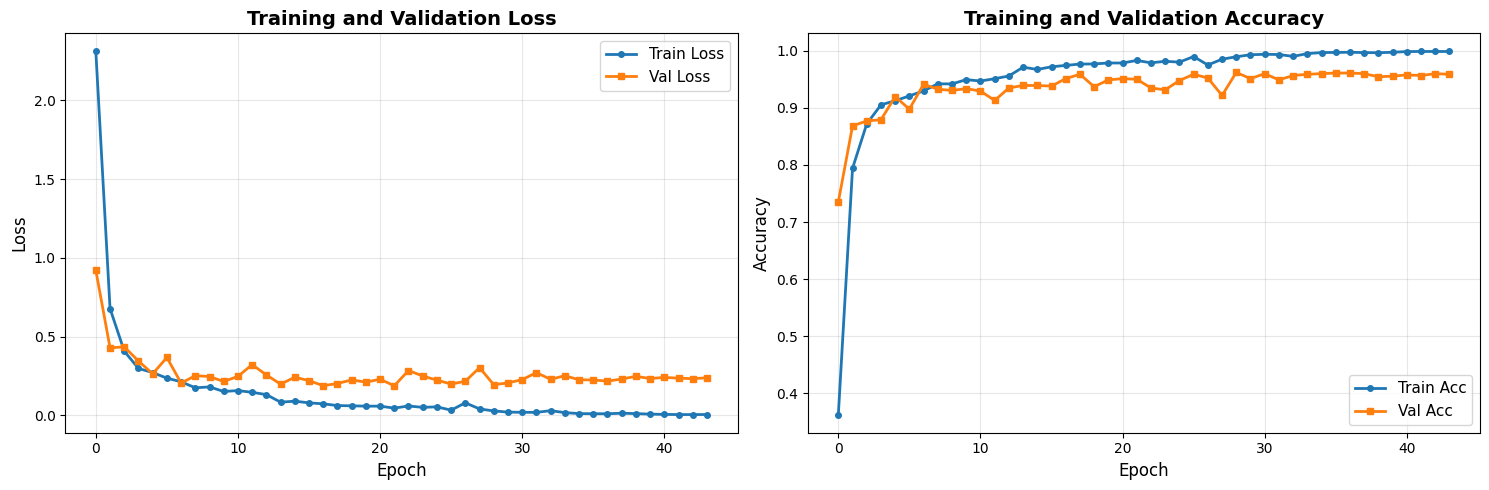

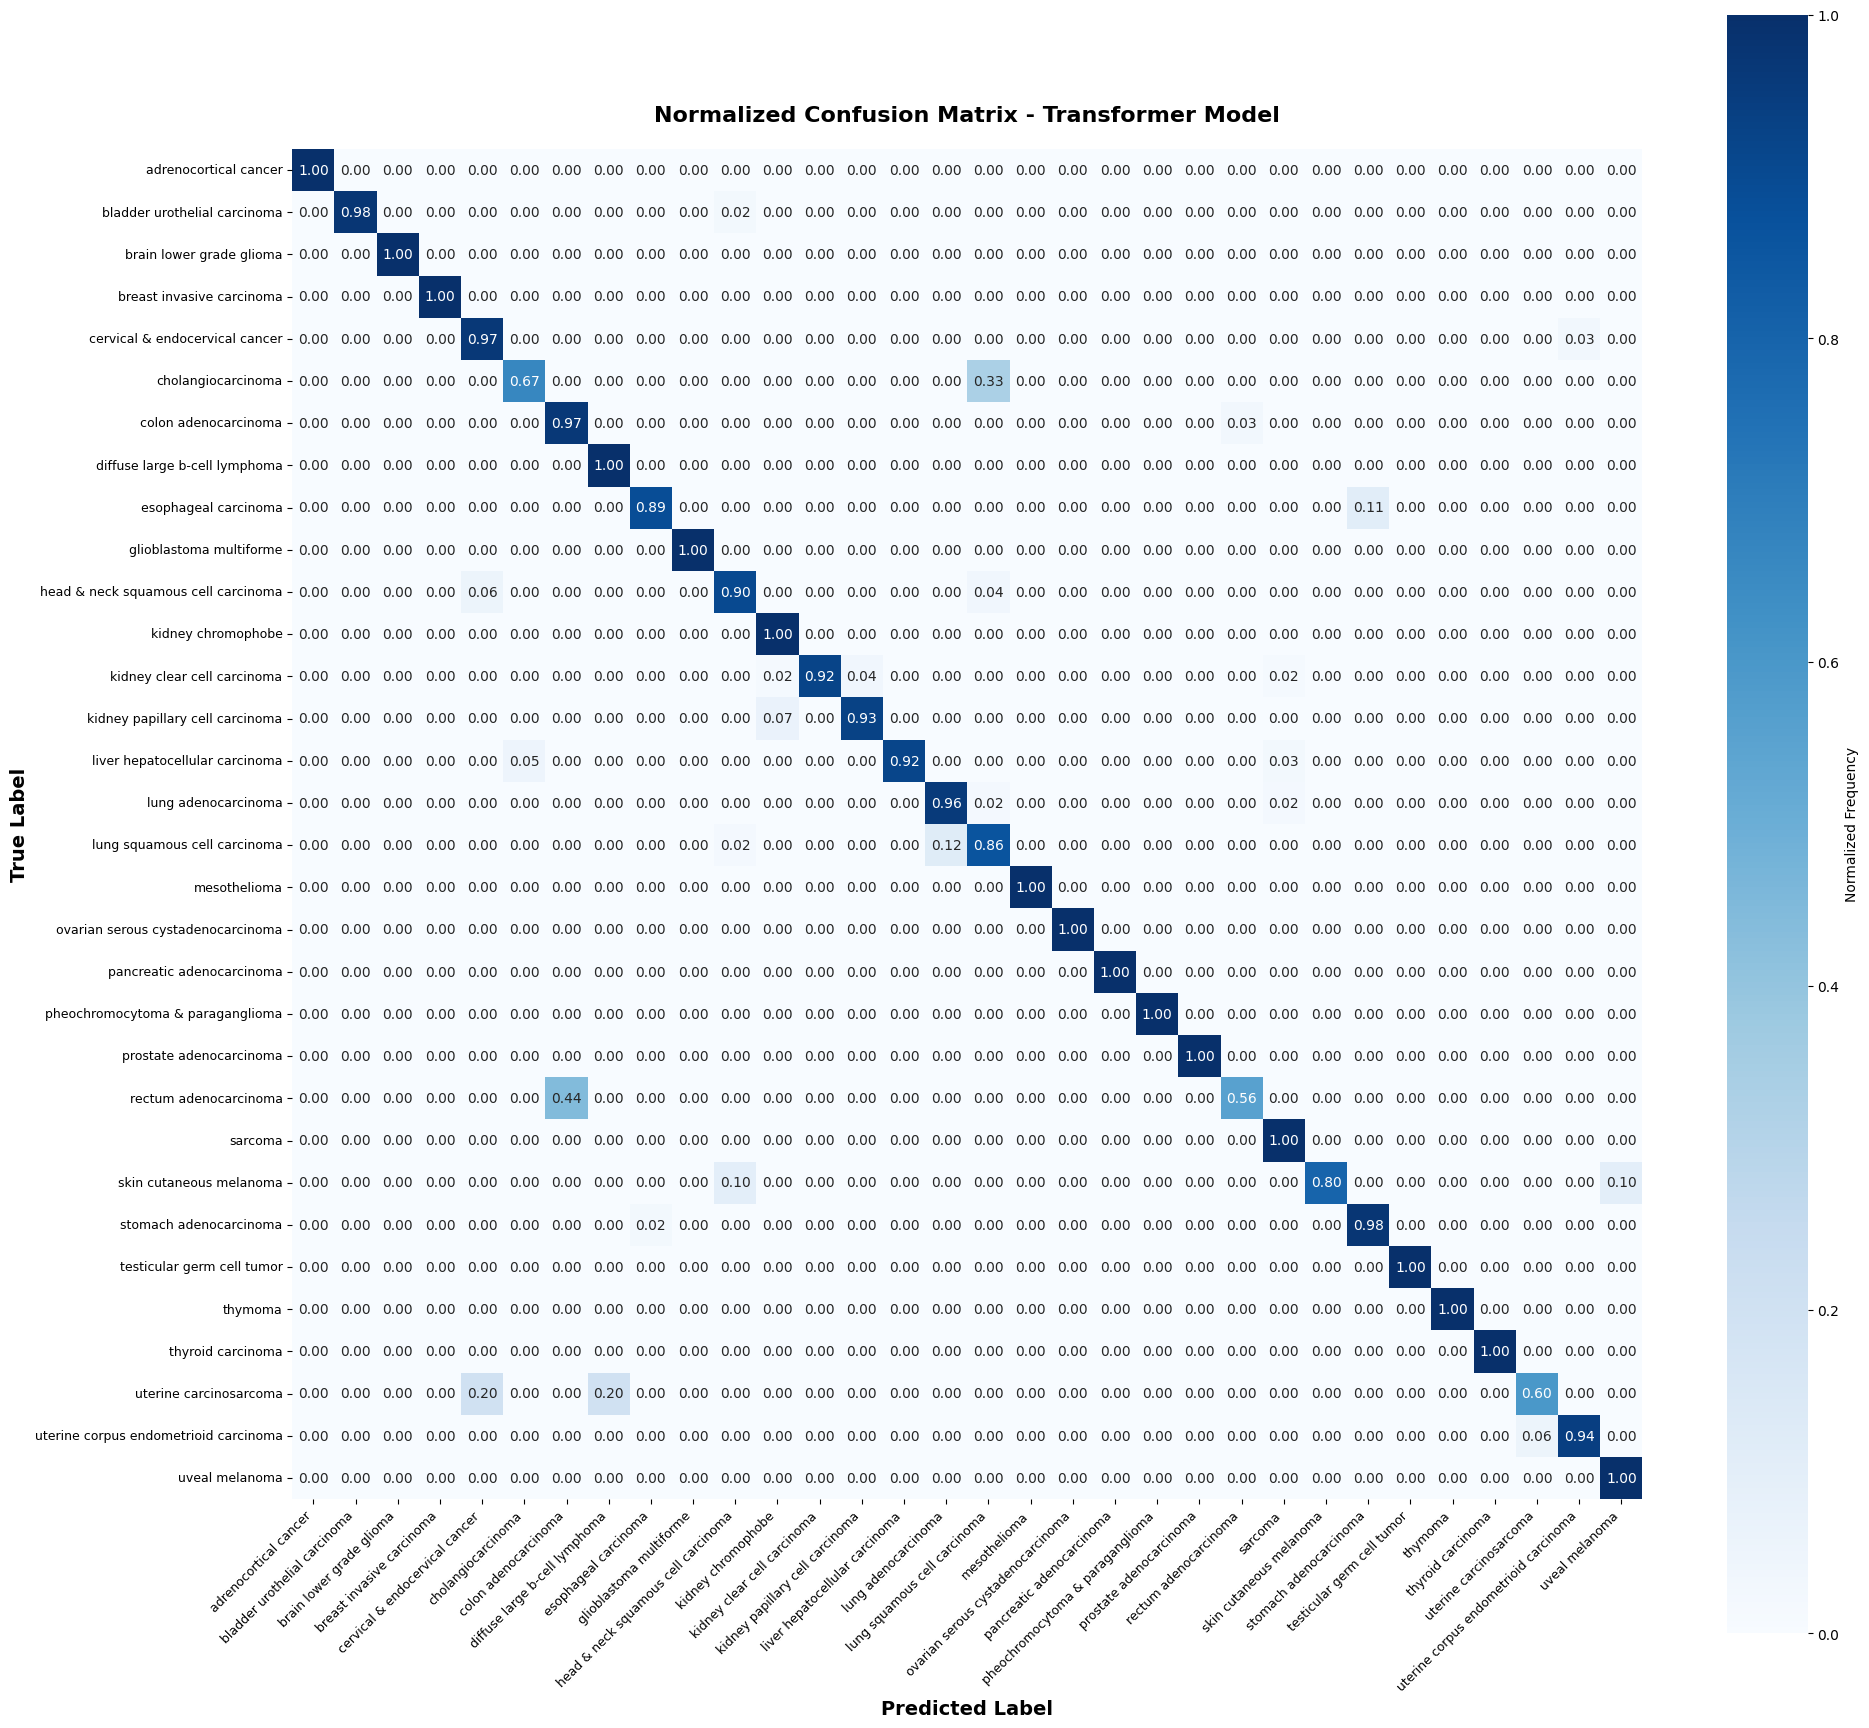

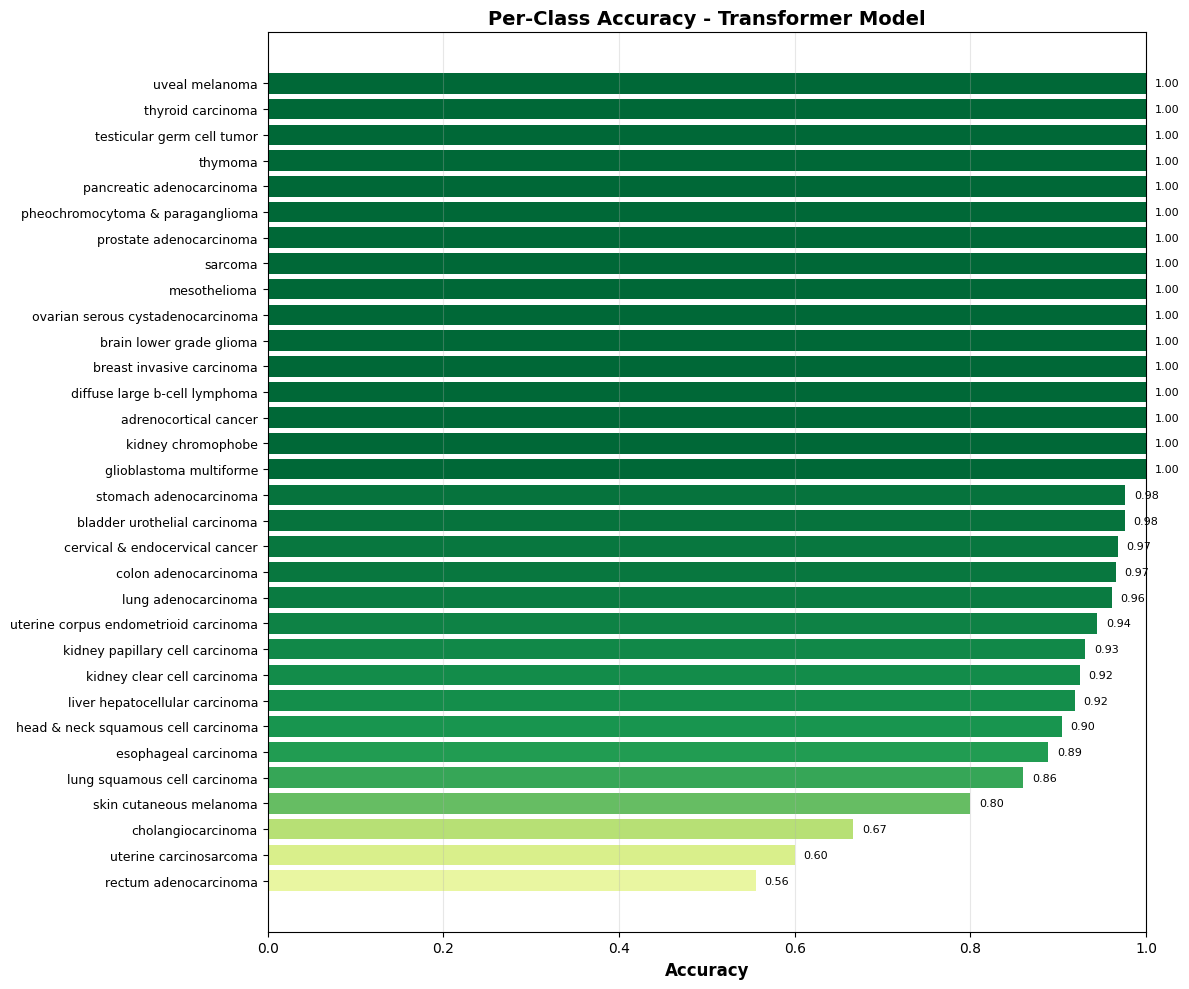

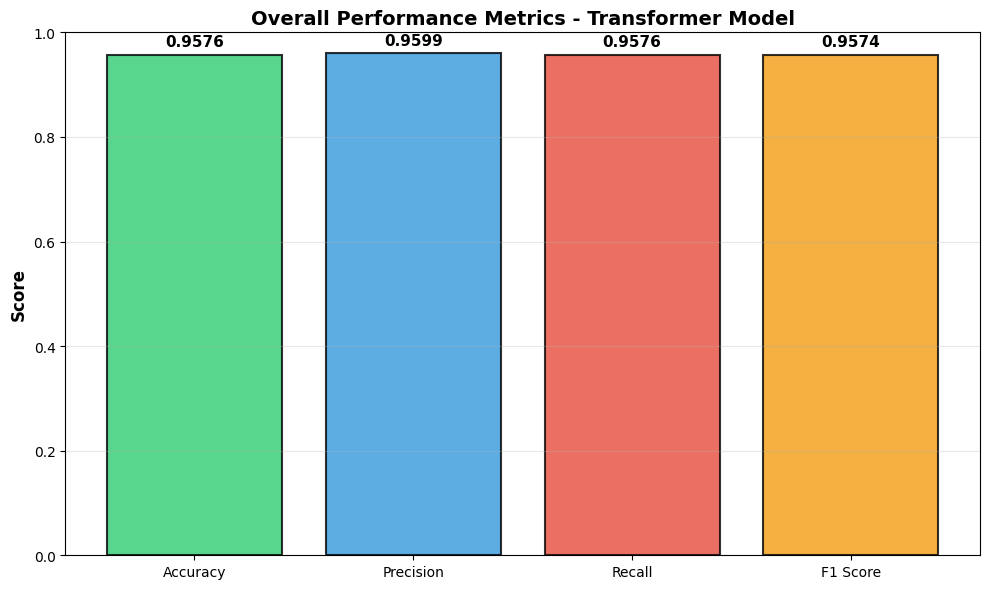

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2, markersize=4)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2, markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2, markersize=4)
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2, markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/transformer_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(20, 18))
class_names = le.classes_

cm_normalized = results['confusion_matrix'].astype('float') / results['confusion_matrix'].sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Normalized Frequency'},
    square=True
)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Normalized Confusion Matrix - Transformer Model', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/transformer_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

per_class_acc = cm_normalized.diagonal()
indices = np.argsort(per_class_acc)

plt.figure(figsize=(12, 10))
colors = plt.cm.RdYlGn(per_class_acc[indices])
bars = plt.barh(range(len(class_names)), per_class_acc[indices], color=colors)
plt.yticks(range(len(class_names)), class_names[indices], fontsize=9)
plt.xlabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Per-Class Accuracy - Transformer Model', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)

for i, (bar, acc) in enumerate(zip(bars, per_class_acc[indices])):
    plt.text(acc + 0.01, i, f'{acc:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/transformer_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [
    results['accuracy'],
    results['precision'],
    results['recall'],
    results['f1_score']
]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'], alpha=0.8, edgecolor='black', linewidth=1.5)
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Overall Performance Metrics - Transformer Model', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/transformer_metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()